---

_You are currently looking at **version 1.2** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-social-network-analysis/resources/yPcBs) course resource._

---

# Assignment 4

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import pickle

---

## Part 1 - Random Graph Identification

For the first part of this assignment you will analyze randomly generated graphs and determine which algorithm created them.

In [2]:
P1_Graphs = pickle.load(open('A4_graphs','rb'))
P1_Graphs

<br>
`P1_Graphs` is a list containing 5 networkx graphs. Each of these graphs were generated by one of three possible algorithms:
* Preferential Attachment (`'PA'`)
* Small World with low probability of rewiring (`'SW_L'`)
* Small World with high probability of rewiring (`'SW_H'`)

Anaylze each of the 5 graphs and determine which of the three algorithms generated the graph.

*The `graph_identification` function should return a list of length 5 where each element in the list is either `'PA'`, `'SW_L'`, or `'SW_H'`.*

['PA', 'SW_L', 'SW_L', 'PA', 'SW_H']

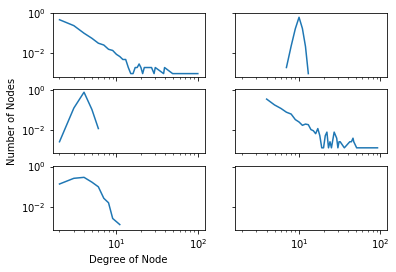

In [3]:
import matplotlib.pyplot as plt
def graph_identification():
    
    graphs = {}
    graphs_degrees = {}
    for i in range(len(P1_Graphs)):
        graphs["G{}".format(i+1)] = P1_Graphs[i]
        graphs_degrees["G{}".format(i+1)] = P1_Graphs[i].degree()
        
    #loop through P1 graphs and create a dictionary of graphs and a dictionary for the graph degree
             
    graphs_degrees_values = {}
    for i, graph in enumerate(graphs_degrees):
        graphs_degrees_values["G{}".format(i+1)] = set(graphs_degrees[graph].values())
    #create dictionary with the set of degree values for each graph
    
    histograms = {}
    for i, graph in enumerate(graphs_degrees_values):
        histogram_values = []
        for j, degree in enumerate(graphs_degrees_values[graph]):
            histogram_values.append(list(graphs_degrees[graph].values()).count(degree)/nx.number_of_nodes(graphs[graph]))
        histograms["G{}".format(i+1)] = histogram_values
        
        #for each node in each graph calculate the ratio of degree/number of nodes 

    fig, axs = plt.subplots(3,2, sharex=True, sharey=True)
    counter = 0
    for i in range(3):
        for j in range(2):
            counter +=1
            axs[i][j].set_xscale('log')
            axs[i][j].set_yscale('log')
            try:
                axs[i][j].plot(list(graphs_degrees_values["G{}".format(counter)]),histograms["G{}".format(counter)])
            except:
                pass
            
    axs[1][0].set_ylabel("Number of Nodes")
    axs[2][0].set_xlabel("Degree of Node")
                
    answer = ['PA','SW_L','SW_L','PA','SW_H']
        
    return answer

graph_identification()

---

## Part 2 - Company Emails

For the second part of this assignment you will be workking with a company's email network where each node corresponds to a person at the company, and each edge indicates that at least one email has been sent between two people.

The network also contains the node attributes `Department` and `ManagementSalary`.

`Department` indicates the department in the company which the person belongs to, and `ManagementSalary` indicates whether that person is receiving a management position salary.

In [4]:
G = nx.read_gpickle('email_prediction.txt')

print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1005
Number of edges: 16706
Average degree:  33.2458


### Part 2A - Salary Prediction

Using network `G`, identify the people in the network with missing values for the node attribute `ManagementSalary` and predict whether or not these individuals are receiving a management position salary.

To accomplish this, you will need to create a matrix of node features using networkx, train a sklearn classifier on nodes that have `ManagementSalary` data, and predict a probability of the node receiving a management salary for nodes where `ManagementSalary` is missing.



Your predictions will need to be given as the probability that the corresponding employee is receiving a management position salary.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC).

Your grade will be based on the AUC score computed for your classifier. A model which with an AUC of 0.88 or higher will receive full points, and with an AUC of 0.82 or higher will pass (get 80% of the full points).

Using your trained classifier, return a series of length 252 with the data being the probability of receiving management salary, and the index being the node id.

    Example:
    
        1       1.0
        2       0.0
        5       0.8
        8       1.0
            ...
        996     0.7
        1000    0.5
        1001    0.0
        Length: 252, dtype: float64

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

def split_data():
    
    index = list(nx.get_node_attributes(G,'Department').keys())
    df = pd.DataFrame(index = index)
    
    df['Department'] = list(nx.get_node_attributes(G,'Department').values())
    df['Clustering'] = list(nx.clustering(G).values())
    df['Degree'] = list(G.degree().values())
    df['PageRank'] = nx.pagerank(G,alpha=0.85).values()
    df['ManagementSalary'] = list(nx.get_node_attributes(G,'ManagementSalary').values())
    
    hold_out_data = df.loc[df['ManagementSalary'].isnull()]
    training_data = df.loc[~df['ManagementSalary'].isnull()]
    X_hold_out = hold_out_data.iloc[:,0:-1]
     
    X_train, X_test, y_train, y_test = train_test_split(training_data.iloc[:,0:-1],
                                                        training_data['ManagementSalary'], 
                                                        test_size = 0.25, random_state = 1)
    
    return X_train, X_test, y_train, y_test, X_hold_out, hold_out_data

In [8]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix
import xgboost

def pick_classifier():
    
    X_train, X_test, y_train, y_test, _, _ = split_data()
    
    classifiers = []
    
    model1 = LogisticRegression(solver = 'liblinear')
    classifiers.append(model1)
        
    model2 = DecisionTreeClassifier(max_features = 'auto')
    classifiers.append(model2)
        
    model4 = RandomForestClassifier()
    classifiers.append(model4)
    
    model5 = xgboost.XGBClassifier()
    classifiers.append(model5)
    
    model6 = AdaBoostClassifier()
    classifiers.append(model6)
    
    model7 = GaussianNB()
    classifiers.append(model7)
    
    for clf in classifiers:
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test,y_pred)
        print("Accuracy of {} is: {}".format(clf,acc))
        cm = confusion_matrix(y_test,y_pred)
        print("Confusion Matrix of {} is \n{}".format(clf,cm))
        try:
            print("ROC_AUC score: {}".format(roc_auc_score(y_test,clf.predict_proba(X_test)[:,1])))
        except:
            print("ROC_AUC score: {}".format(roc_auc_score(y_test,clf.decision_function(X_test))))

pick_classifier()

Accuracy of LogisticRegression(solver='liblinear') is: 0.9047619047619048
Confusion Matrix of LogisticRegression(solver='liblinear') is 
[[159   0]
 [ 18  12]]
ROC_AUC score: 0.9213836477987422
Accuracy of DecisionTreeClassifier(max_features='auto') is: 0.8888888888888888
Confusion Matrix of DecisionTreeClassifier(max_features='auto') is 
[[151   8]
 [ 13  17]]
ROC_AUC score: 0.7581761006289308
Accuracy of RandomForestClassifier() is: 0.8941798941798942
Confusion Matrix of RandomForestClassifier() is 
[[153   6]
 [ 14  16]]
ROC_AUC score: 0.9473794549266247
Accuracy of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random

In [9]:
from sklearn.ensemble import RandomForestClassifier

def predict_manager_salary():   
    
    X_train, X_test, y_train, y_test, X_hold_out, hold_out_data = split_data()
    
    clf = RandomForestClassifier(max_features = 'auto').fit(X_train,y_train)
    y_hold_out_pred = clf.predict_proba(X_hold_out)
           
    manager_salary_probabilities = pd.Series(y_hold_out_pred[:,1], index = hold_out_data.index)
    
    return manager_salary_probabilities

predict_manager_salary()

1       0.06
2       0.83
5       0.98
8       0.36
14      0.17
        ... 
992     0.00
994     0.00
996     0.00
1000    0.01
1001    0.00
Length: 252, dtype: float64

### Part 2B - New Connections Prediction

For the last part of this assignment, you will predict future connections between employees of the network. The future connections information has been loaded into the variable `future_connections`. The index is a tuple indicating a pair of nodes that currently do not have a connection, and the `Future Connection` column indicates if an edge between those two nodes will exist in the future, where a value of 1.0 indicates a future connection.

In [10]:
future_connections = pd.read_csv('Future_Connections.csv', index_col=0, converters={0: eval})
future_connections.head(1)

,Future Connection
"(6, 840)",0.0


Using network `G` and `future_connections`, identify the edges in `future_connections` with missing values and predict whether or not these edges will have a future connection.

To accomplish this, you will need to create a matrix of features for the edges found in `future_connections` using networkx, train a sklearn classifier on those edges in `future_connections` that have `Future Connection` data, and predict a probability of the edge being a future connection for those edges in `future_connections` where `Future Connection` is missing.



Your predictions will need to be given as the probability of the corresponding edge being a future connection.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC).

Your grade will be based on the AUC score computed for your classifier. A model which with an AUC of 0.88 or higher will receive full points, and with an AUC of 0.82 or higher will pass (get 80% of the full points).

Using your trained classifier, return a series of length 122112 with the data being the probability of the edge being a future connection, and the index being the edge as represented by a tuple of nodes.

    Example:
    
        (107, 348)    0.35
        (542, 751)    0.40
        (20, 426)     0.55
        (50, 989)     0.35
                  ...
        (939, 940)    0.15
        (555, 905)    0.35
        (75, 101)     0.65
        Length: 122112, dtype: float64

In [13]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
import networkx as nx

def split_data1():
    
    future_connections['preferential attachment'] = [i[2] for i in nx.preferential_attachment(G,future_connections.index)]
    future_connections['common neighbors'] = future_connections.index.map(lambda node: len(list(nx.common_neighbors(G,node[0],node[1]))))
    future_connections['common neighbors'] = future_connections['common neighbors']**3
    
    hold_out_data = future_connections.loc[future_connections['Future Connection'].isnull()]
    training_data = future_connections.loc[~future_connections['Future Connection'].isnull()]
    
    X_train, X_test, y_train, y_test = train_test_split(training_data[['preferential attachment','common neighbors']],
                                                                        training_data['Future Connection'],
                                                                        test_size = 0.25,
                                                                        random_state = 2)
    return X_train, X_test, y_train, y_test, hold_out_data
    
split_data1()

(            preferential attachment  common neighbors
 (305, 410)                      682                 1
 (77, 387)                      1025                 1
 (734, 743)                       70                 0
 (158, 500)                     1029                 0
 (968, 997)                       12                 0
 ...                             ...               ...
 (154, 418)                     1620                27
 (265, 709)                      117                 0
 (331, 429)                      816                 1
 (165, 907)                     1666                 0
 (19, 988)                       144                 0
 
 [274750 rows x 2 columns],
             preferential attachment  common neighbors
 (497, 879)                       17                 0
 (719, 897)                       15                 0
 (197, 260)                      851                 1
 (247, 674)                      340               343
 (731, 813)                       4

In [14]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix
import xgboost

def pick_classifier():
    
    X_train, X_test, y_train, y_test, _ = split_data1()
    
    classifiers = []
    
    model1 = LogisticRegression(solver = 'liblinear')
    classifiers.append(model1)
        
    model2 = DecisionTreeClassifier(max_features = 'auto')
    classifiers.append(model2)
        
    model4 = RandomForestClassifier()
    classifiers.append(model4)
    
    model5 = xgboost.XGBClassifier()
    classifiers.append(model5)
    
    model6 = AdaBoostClassifier()
    classifiers.append(model6)
    
    model7 = GaussianNB()
    classifiers.append(model7)
    
    for clf in classifiers:
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test,y_pred)
        print("Accuracy of {} is: {}".format(clf,acc))
        cm = confusion_matrix(y_test,y_pred)
        print("Confusion Matrix of {} is \n{}".format(clf,cm))
        try:
            print("ROC_AUC score: {}".format(roc_auc_score(y_test,clf.predict_proba(X_test)[:,1])))
        except:
            print("ROC_AUC score: {}".format(roc_auc_score(y_test,clf.decision_function(X_test))))

pick_classifier()

Accuracy of LogisticRegression(solver='liblinear') is: 0.9553961390635919
Confusion Matrix of LogisticRegression(solver='liblinear') is 
[[83752   474]
 [ 3611  3747]]
ROC_AUC score: 0.9027349545396272
Accuracy of DecisionTreeClassifier(max_features='auto') is: 0.9537037037037037
Confusion Matrix of DecisionTreeClassifier(max_features='auto') is 
[[83192  1034]
 [ 3206  4152]]
ROC_AUC score: 0.7891745417058225
Accuracy of RandomForestClassifier() is: 0.9535945143256463
Confusion Matrix of RandomForestClassifier() is 
[[83004  1222]
 [ 3028  4330]]
ROC_AUC score: 0.8532004622854003
Accuracy of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

def param_test():
    
    X_train, X_test, y_train, y_test, _ = split_data1()
    
    param_grid = {'C': [0.001,0.01,0.1,1], 
                  'penalty': ['l1','l2']}
    
    gsearch = GridSearchCV(estimator = LogisticRegression(solver = 'liblinear'),
                          param_grid = param_grid,
                          scoring = 'roc_auc',
                          n_jobs = 4,
                          cv = 5)
    
    gsearch.fit(X_train,y_train)
    
    print(gsearch.best_params_)
       
param_test()

{'C': 0.01, 'penalty': 'l2'}


In [28]:
def predict_connection():
    
    X_train, X_test, y_train, y_test, hold_out_data = split_data1()
    
    clf = LogisticRegression(C=.01,penalty='l2').fit(X_train,y_train)
    y_proba = clf.decision_function(X_test)
    
    hold_out_data_predicted = clf.predict_proba(hold_out_data[['preferential attachment','common neighbors']])
    future_connection_probability = pd.Series(hold_out_data_predicted[:,1], index = hold_out_data.index)
  
    return future_connection_probability

predict_connection()

(107, 348)    0.033211
(542, 751)    0.031769
(20, 426)     0.658219
(50, 989)     0.031737
(942, 986)    0.031702
                ...   
(165, 923)    0.032104
(673, 755)    0.031700
(939, 940)    0.031702
(555, 905)    0.031789
(75, 101)     0.032184
Length: 122112, dtype: float64